In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from math import sqrt
from datetime import datetime, timedelta
from pickle import dump

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, GRU
import tensorflow as tf

In [ ]:
data_dir = "Data"

## Data

In [ ]:
tickers = ["AAPL", "AMZN", "GOOGL", "MSFT", "TSLA"]
stock_data = dict()
scalers = dict()

In [ ]:
for ticker in tickers:
    stock_data[ticker] = pd.read_csv("/content/drive/My Drive/Stock Prediction/{}/STOCK_DATA_{}.csv".format(data_dir, ticker))
    stock_data[ticker].drop(columns=["Unnamed: 0", "Volume"], inplace=True)
    stock_data[ticker].sort_values(by="Date")
    stock_data[ticker].drop(columns=["Date"], inplace=True)
    scaler_ = MinMaxScaler(feature_range=(0, 1))
    stock_data[ticker][["Open", "High", "Low", "Close"]] = scaler_.fit_transform(stock_data[ticker][["Open", "High", "Low", "Close"]].values.reshape(-1,4))
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data[ticker]["Adj Close"] = scaler.fit_transform(stock_data[ticker]["Adj Close"].values.reshape(-1,1))
    scalers[ticker] = scaler
    # print(len(stock_data[ticker]))
    # print(stock_data[ticker].head())

## Pre-processing

In [ ]:
timeSeriesDataX = dict()
timeSeriesDataY = dict()

In [ ]:
for ticker in tickers:
    # if ticker != "AAPL":
    data = list()
    for idx in range(len(stock_data[ticker])-20):
        data.append(stock_data[ticker][idx:idx+21])
    data = np.array(data)
    timeSeriesDataX[ticker] = data[:,:-1,:]
    timeSeriesDataY[ticker] = data[:,-1,4]

In [ ]:
X = np.concatenate(list(timeSeriesDataX.values()), axis=0)
y = np.concatenate(list(timeSeriesDataY.values()), axis=0)

In [ ]:
X.shape, y.shape

((6152, 20, 8), (6152,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4921, 20, 8) (4921,) (1231, 20, 8) (1231,)


## LSTM

In [ ]:
def build_rnn_model():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(20, 8)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model

In [ ]:
model_lstm = build_rnn_model()

In [ ]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
154/154 [==============================] - 7s 8ms/step - loss: 0.0078
Epoch 2/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0032
Epoch 3/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0029
Epoch 4/50
154/154 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 5/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0027
Epoch 6/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0023
Epoch 7/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 8/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0020
Epoch 9/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 10/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 11/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 12/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 13/50
154/154 [=

In [ ]:
y_pred = model_lstm.predict(X_test)

39/39 [==============================] - 1s 3ms/step


In [ ]:
print("RMSE LSTM: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE LSTM:  0.02357292955614391


In [ ]:
timeSeriesDataY_pred_aapl_lstm = model_lstm.predict(timeSeriesDataX["AAPL"])

38/38 [==============================] - 0s 4ms/step


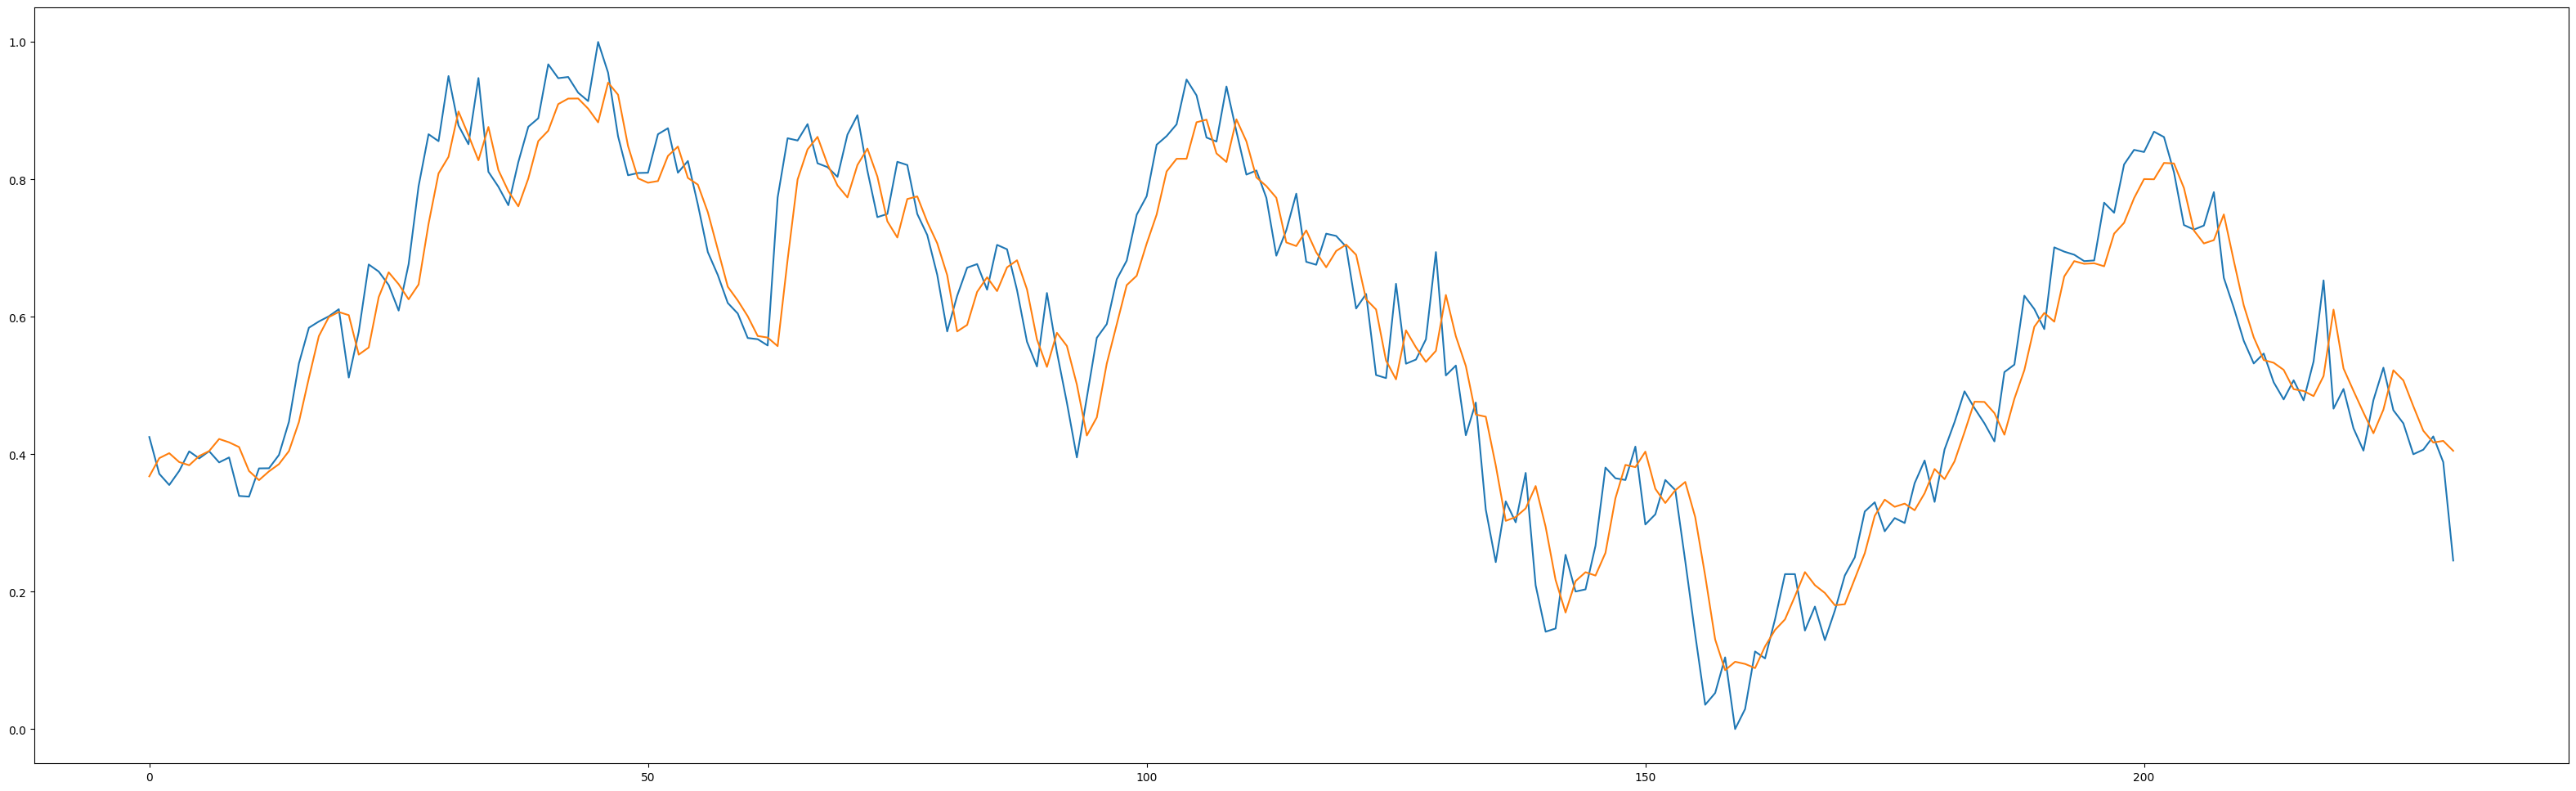

In [ ]:
# plt.figure(figsize=(40,12))
# plt.plot(timeSeriesDataY["AAPL"])
# plt.plot(timeSeriesDataY_pred_aapl)

In [ ]:
model_lstm.save("/content/drive/My Drive/Stock Prediction/{}/lstm.h5".format(data_dir))

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train_rf, y_train)

# Make predictions on the test data
y_pred = model_rf.predict(X_test_rf)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 0.01765929506697174


In [ ]:
timeSeriesDataX_rf_aapl = timeSeriesDataX["AAPL"].reshape(timeSeriesDataX["AAPL"].shape[0], -1)

In [ ]:
timeSeriesDataY_pred_aapl_rf = model_rf.predict(timeSeriesDataX_rf_aapl)

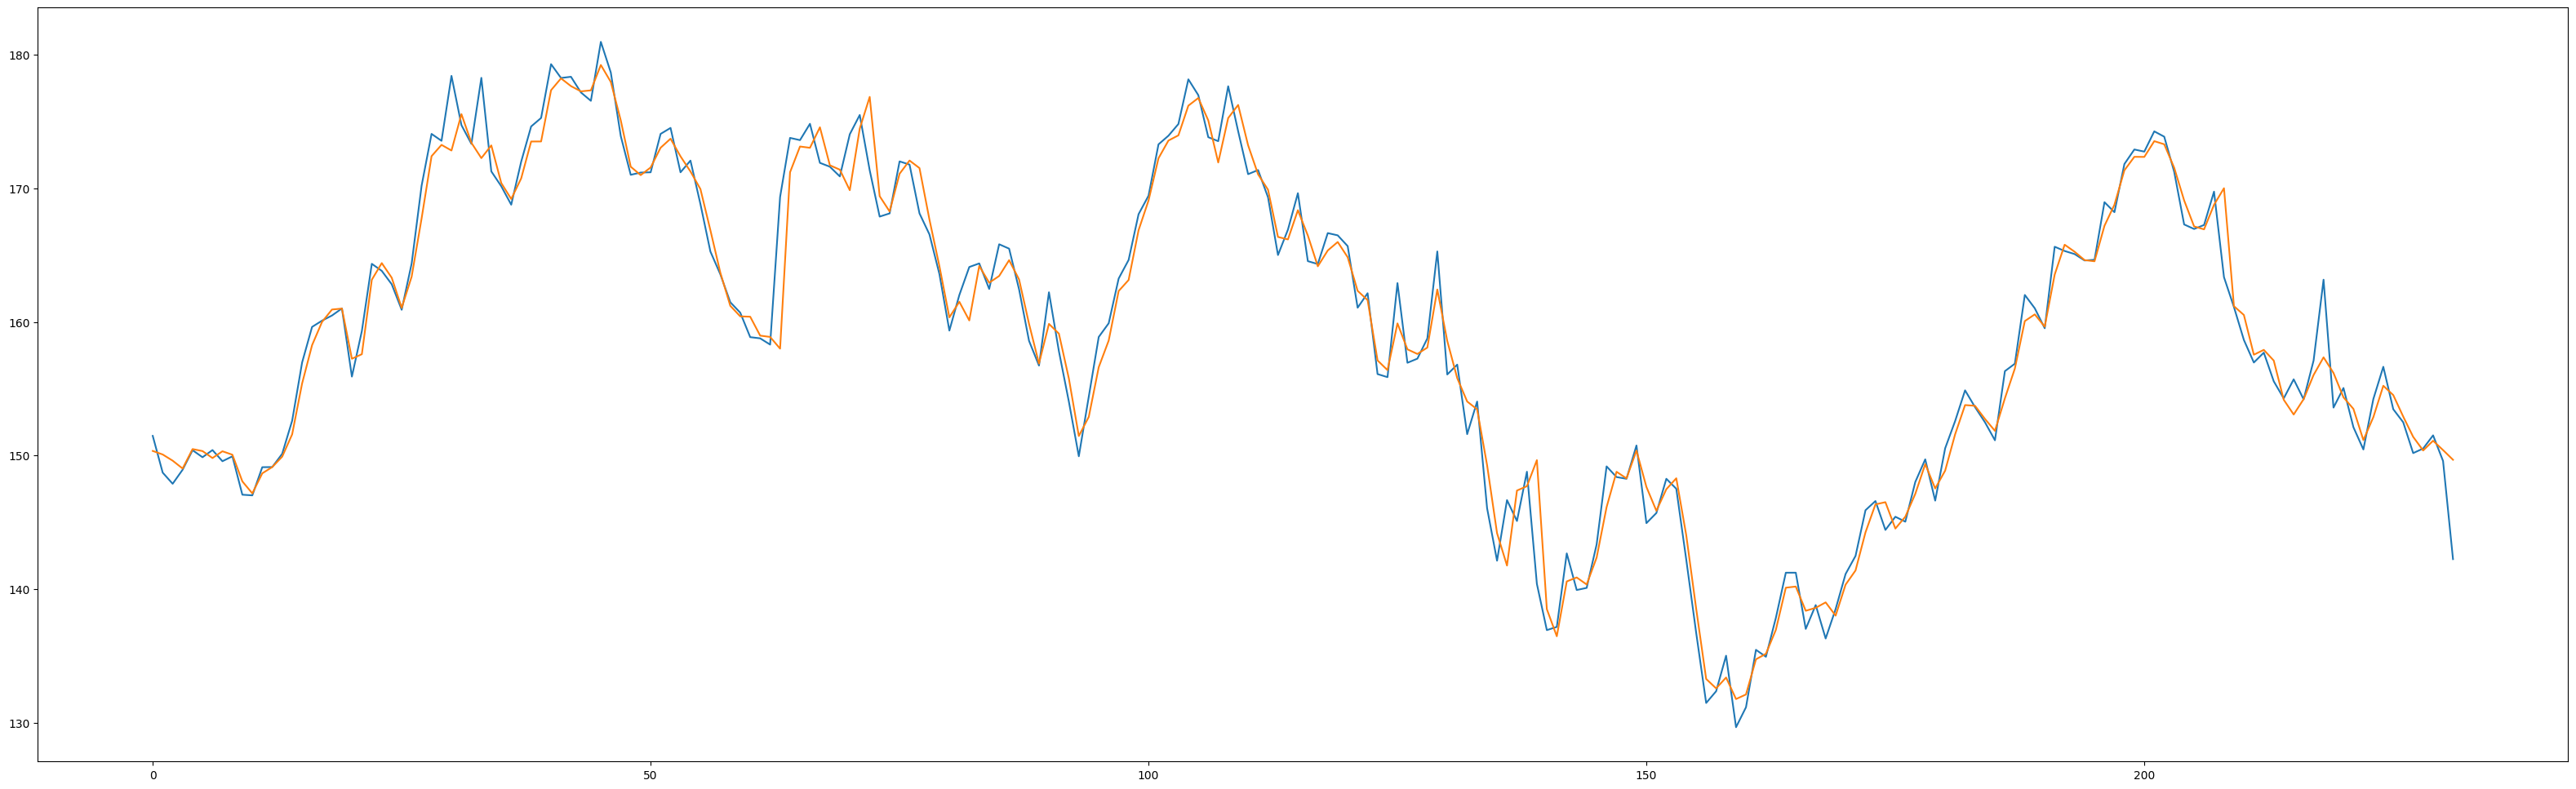

In [ ]:
# plt.figure(figsize=(40,12))
# plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY["AAPL"].reshape(-1, 1)))
# plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl.reshape(-1, 1)))
# plt.savefig('/content/drive/My Drive/Stock Prediction/Dataset2/RF.png', bbox_inches='tight')

In [ ]:
import joblib

joblib.dump(model_rf, "/content/drive/My Drive/Stock Prediction/{}/RF.joblib".format(data_dir))
# model_rf = joblib.load("/content/drive/My Drive/Stock Prediction/Dataset2/RF.joblib")

['/content/drive/My Drive/Stock Prediction/Data/RF.joblib']

## GRU

In [ ]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=64, return_sequences=True, input_shape=(20, 8)))
    model.add(Dropout(0.2))
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=64))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model

In [ ]:
model_gru = build_gru_model()

In [ ]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
154/154 [==============================] - 8s 9ms/step - loss: 0.0078
Epoch 2/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0027
Epoch 3/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0024
Epoch 4/50
154/154 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 5/50
154/154 [==============================] - 2s 11ms/step - loss: 0.0019
Epoch 6/50
154/154 [==============================] - 1s 9ms/step - loss: 0.0017
Epoch 7/50
154/154 [==============================] - 2s 12ms/step - loss: 0.0016
Epoch 8/50
154/154 [==============================] - 1s 8ms/step - loss: 0.0015
Epoch 9/50
154/154 [==============================] - 2s 12ms/step - loss: 0.0015
Epoch 10/50
154/154 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 11/50
154/154 [==============================] - 2s 10ms/step - loss: 0.0014
Epoch 12/50
154/154 [==============================] - 1s 9ms/step - loss: 0.0014
Epoch 13/50
154/15

In [ ]:
y_pred = model_gru.predict(X_test)

39/39 [==============================] - 2s 5ms/step


In [ ]:
print("RMSE GRU: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE GRU:  0.014346624127413759


In [ ]:
timeSeriesDataY_pred_aapl_gru = model_gru.predict(timeSeriesDataX["AAPL"])

38/38 [==============================] - 0s 4ms/step


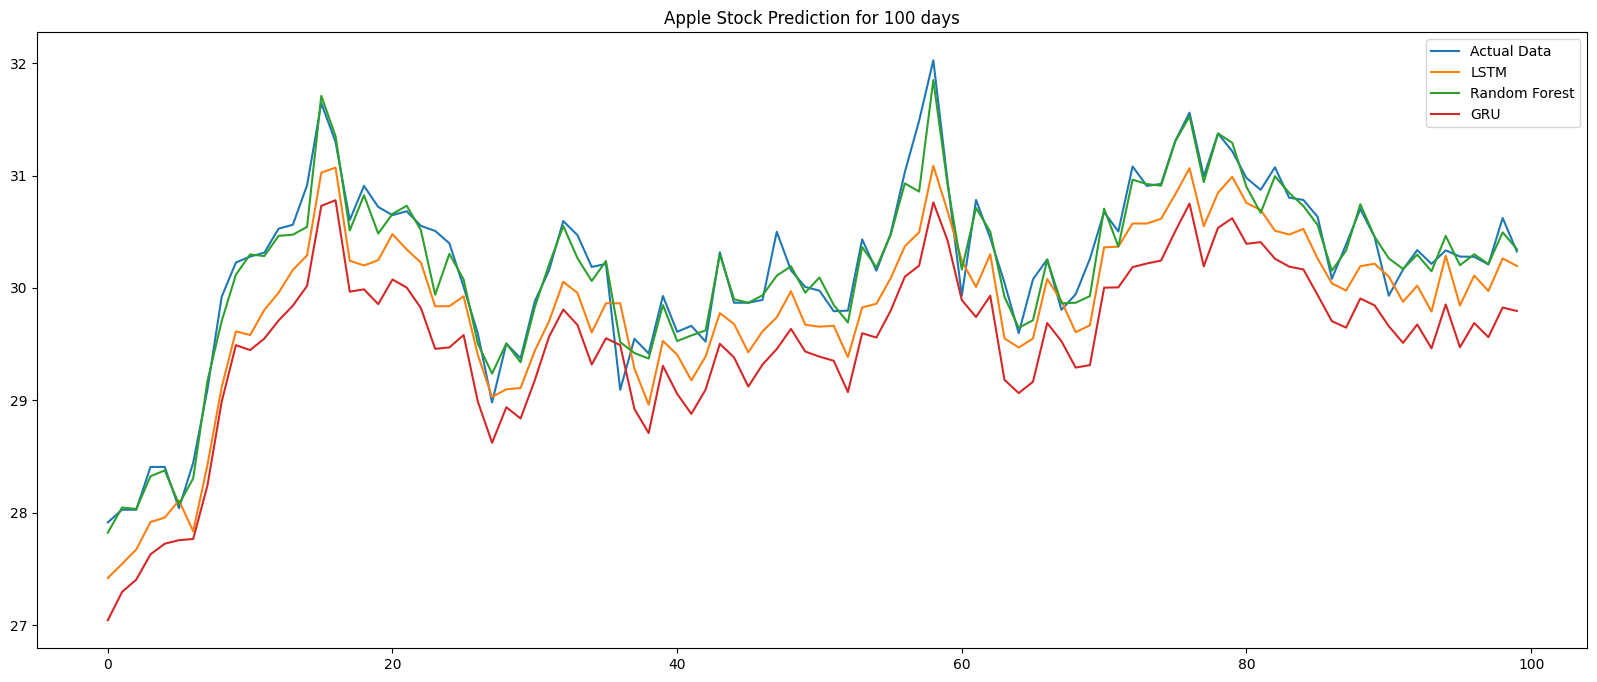

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Apple Stock Prediction for 100 days")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY["AAPL"][:100].reshape(-1,1)), label="Actual Data")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_lstm[:100].reshape(-1,1)), label="LSTM")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_rf[:100].reshape(-1,1)), label="Random Forest")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_gru[:100].reshape(-1,1)), label="GRU")
plt.legend()

In [ ]:
model_gru.save("/content/drive/My Drive/Stock Prediction/Data/GRU.h5")

## ARIMA

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00


In [ ]:
X_arima_amzn = stock_data["AMZN"].copy()
X_arima_amzn["Adj Close"] = X_arima_amzn["Adj Close"].shift(-1)
X_arima_amzn.dropna(inplace=True)
y_arima_amzn = X_arima_amzn["Adj Close"].copy()
X_arima_amzn.drop(columns="Adj Close", inplace=True)

In [ ]:
X_train_arima_amzn = X_arima_amzn[:1000]
X_test_arima_amzn = X_arima_amzn[1000:]
y_train_arima_amzn = y_arima_amzn[:1000]
y_test_arima_amzn = y_arima_amzn[1000:]

In [ ]:
model_arm = auto_arima(y_train_arima_amzn, exogenous=X_train_arima_amzn, start_p=2, d=None, start_q=3,
                       max_p=5, max_d=3, max_q=5, D=None, start_Q=1, max_P=2,
                       max_D=1, max_Q=2, max_order=5, seasonal=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True
                       )

In [ ]:
y_test_pred = model_arm.predict(n_periods=len(X_test_arima_amzn), exogenous=X_test_arima_amzn)

In [ ]:
print("RMSE ARIMA: ", np.sqrt(mean_squared_error(y_test_arima_amzn, y_test_pred)))

RMSE ARIMA:  0.18632099620596854


In [ ]:
y_test_arima_amzn

1000    0.675555
1001    0.670271
1002    0.679617
1003    0.714486
1004    0.692319
          ...   
1249    0.859343
1250    0.857180
1251    0.902577
1252    0.903164
1253    0.890092
Name: Adj Close, Length: 254, dtype: float64

In [ ]:
y_test_pred

1000    0.603718
1001    0.604313
1002    0.604908
1003    0.605503
1004    0.606098
          ...   
1249    0.751874
1250    0.752469
1251    0.753064
1252    0.753659
1253    0.754254
Length: 254, dtype: float64

In [ ]:
timeSeriesDataY_pred_aapl = model_arm.predict(n_periods=len(timeSeriesDataX["AAPL"]), exogenous=timeSeriesDataX["AAPL"])

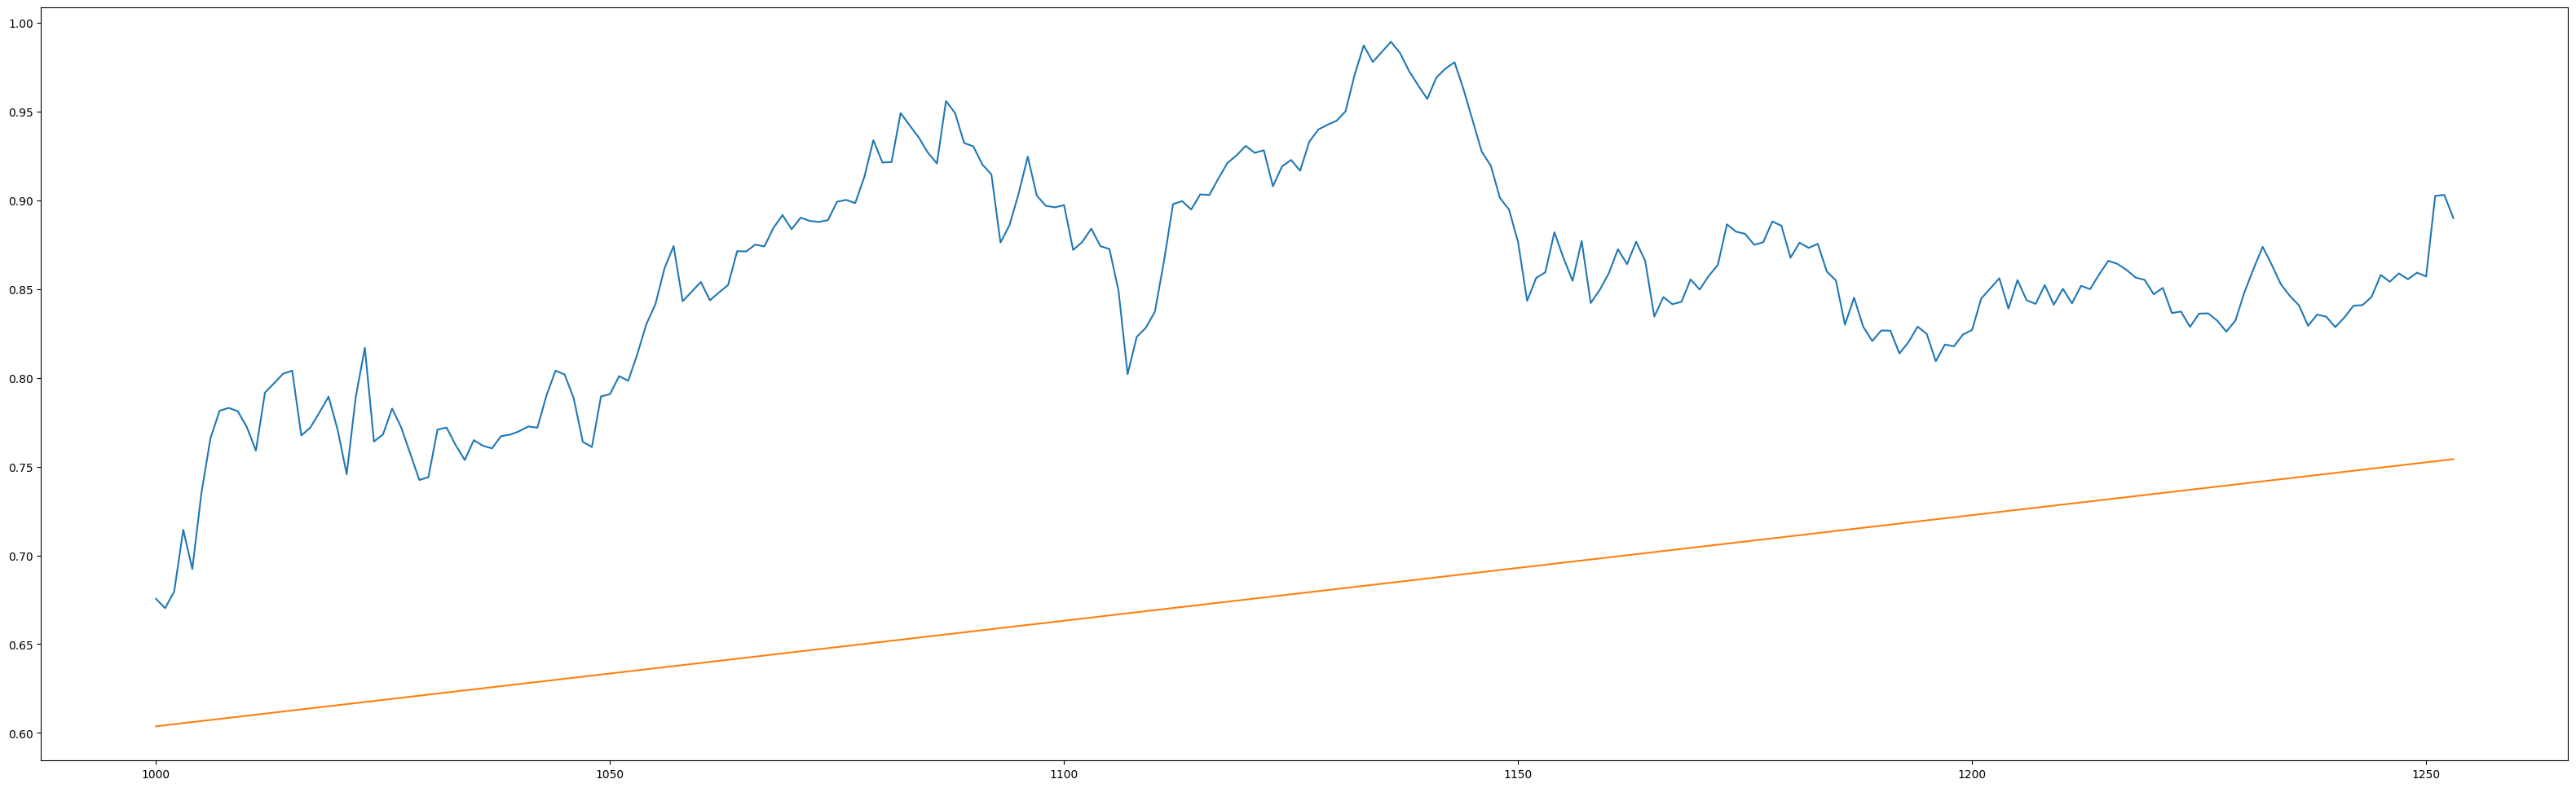

In [ ]:
plt.figure(figsize=(40,12))
plt.plot(y_test_arima_amzn)
plt.plot(y_test_pred)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
dataX_ticker = dict()
dataY_ticker = dict()
for ticker in tickers:
    X_ticker = stock_data[ticker].copy()
    X_ticker["Adj Close Target"] = X_ticker["Adj Close"].shift(-1)
    X_ticker.dropna(inplace=True)
    y_ticker = X_ticker["Adj Close Target"].copy()
    X_ticker.drop(columns="Adj Close Target", inplace=True)
    dataX_ticker[ticker] = X_ticker
    dataY_ticker[ticker] = y_ticker

In [ ]:
dataX = pd.concat(list(dataX_ticker.values()))
dataY = pd.concat(list(dataY_ticker.values()))

In [ ]:
len(dataX), len(dataY)

(6247, 6247)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model_lr.predict(X_test)

In [ ]:
print("RMSE Linear Regression: ", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE Linear Regression:  0.017096605691701978


In [ ]:
timeSeriesDataY_pred_aapl_lr = model_lr.predict(dataX_ticker["AAPL"])

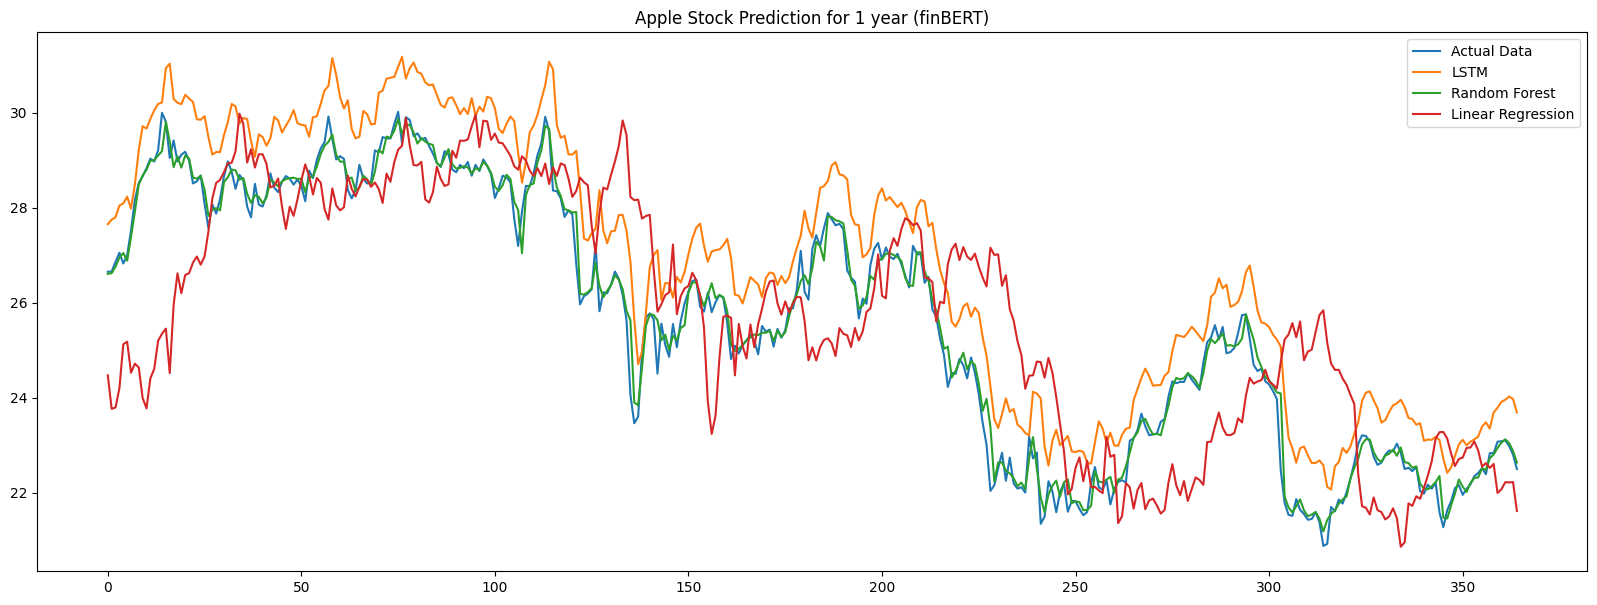

In [ ]:
plt.figure(figsize=(20,7))
plt.title("Apple Stock Prediction for 1 year (finBERT)")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY["AAPL"][:365].reshape(-1,1)), label="Actual Data")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_lstm[:365].reshape(-1,1)), label="LSTM")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_rf[:365].reshape(-1,1)), label="Random Forest")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_lr[:365].reshape(-1,1)), label="Linear Regression")
plt.legend()

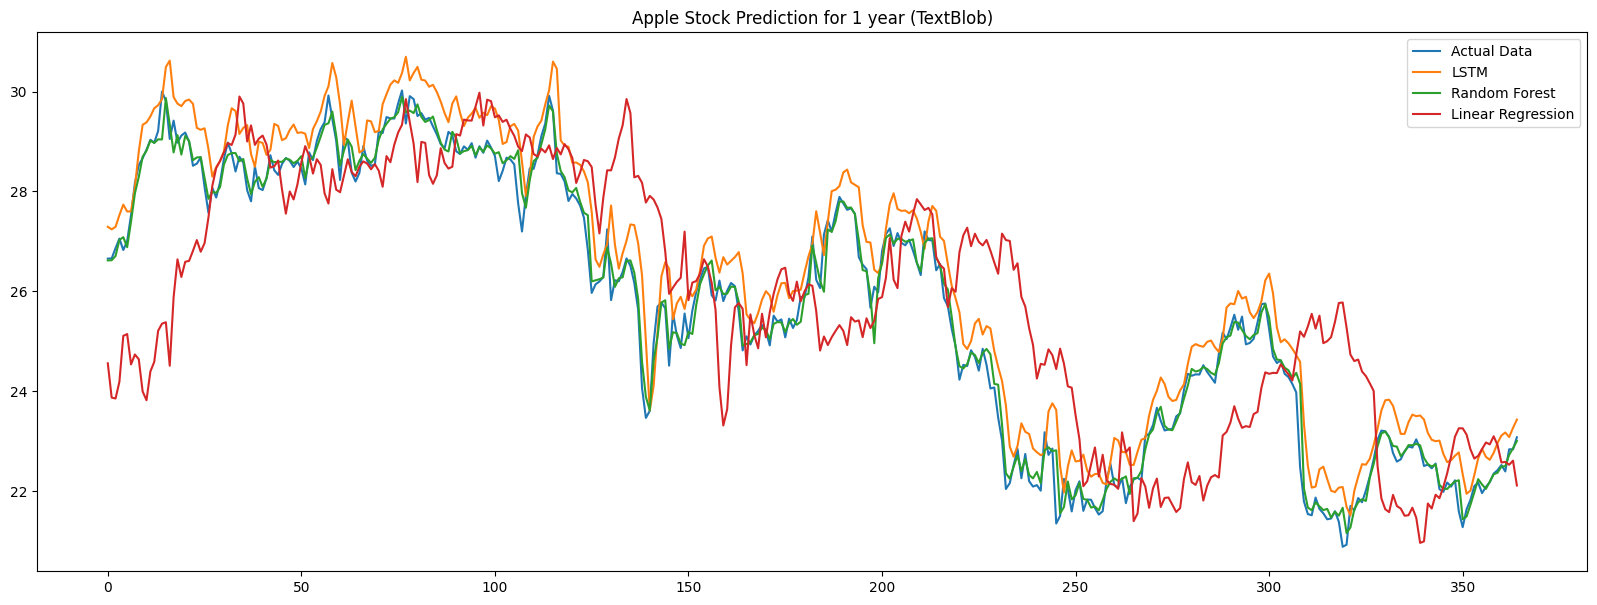

In [ ]:
plt.figure(figsize=(20,7))
plt.title("Apple Stock Prediction for 1 year (TextBlob)")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY["AAPL"][:365].reshape(-1,1)), label="Actual Data")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_lstm[:365].reshape(-1,1)), label="LSTM")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_rf[:365].reshape(-1,1)), label="Random Forest")
plt.plot(scalers["AAPL"].inverse_transform(timeSeriesDataY_pred_aapl_lr[:365].reshape(-1,1)), label="Linear Regression")
plt.legend()